<a href="https://colab.research.google.com/github/ryan-saloma/teaching-python/blob/main/Project_1_(Taylor_Swift_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries and Data

In [104]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('taylor_swift_spotify.csv')

In [62]:
# Explore the data

# Look at the first few rows
data.head()

# Look at the column names, number of rows, and data types
# Check for missing values
data.info()

# Generate basic summary stats
data.describe()

# Check for duplicates
data['name'].value_counts()

# Attempt to first releases
mask = data['album'].str.contains('Version', case=False, na=False) | \
       data['album'].str.contains('Edition', case=False, na=False) | \
       data['album'].str.contains('Live', case=False, na=False) | \
       data['album'].str.contains('Tour', case=False, na=False) | \
       data['album'].str.contains('Anthology', case=False, na=False)
versions_df = data[mask]
originals_df = data[~mask]

# Inspect album names
originals_df['album'].unique()
versions_df['album'].unique()

# Might be better to filter and keep first release
# Requires that we type cast the release_date column
data['release_date'][1] # Look how release_date is formatted
data['release_date'] = pd.to_datetime(data['release_date'])

# Need to parantheses/brackets from song names
# We want to do this to every name, so a function seems appropriate
def clean_song_name(text):
    # Use regex to find the first occurrence of
    # '(' or '[' and remove everything after it
    return re.split(r'[\(\[]', text)[0].strip()
data['name'] = data['name'].apply(clean_song_name)

# Inspect the results
# Looks like we need to remove everything after an em-dash
data['name'].unique()
def clean_song_name_2(text):
    # Use regex to find the first occurrence of
    # '(' or '[' and remove everything after it
    return re.split(r'[\(\[\--\-]', text)[0].strip()
data['name'] = data['name'].apply(clean_song_name_2)
data['album'] = data['album'].apply(clean_song_name_2)

# Inspect results of running clean_song_name_2
# Looks like it worked
data['name'].unique()

# Now, filter to keep only the firsts release of a song
idx = data.groupby('name')['release_date'].idxmin() # return index (idx) with minimum value (min)
idx # inspect idx
type(idx) # check type of idx
earliest_releases = data.loc[idx].reset_index(drop=True)
earliest_releases.info()


<Axes: title={'center': 'Energy of Folklore Songs'}, ylabel='Frequency'>

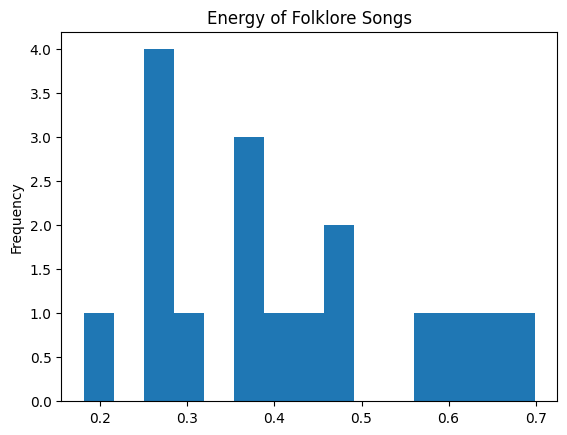

In [108]:
# Summarize the data
earliest_releases_clean =  earliest_releases.iloc[:, 1:] \
.drop(['track_number'], axis=1)
earliest_releases_clean.describe()

# What if we want to remove some columns that aren't useful (like track_number)
# The output of describe is a DataFrame, so we can select columns
summary_earliest_releases = earliest_releases \
.describe(include=[np.number])

# Okay, we got some results, so let's save them to a csv file
summary_earliest_releases.to_csv('earliest_releases_summary.csv', index=False)

# Okay, but what if we want to summarize by album
earliest_releases_clean.groupby('album').describe() \
.to_csv('summary_by_album.csv', index=True)

# Looks like there's some variability
# On average, what's the lowest energy album? What about highest?
# Notice, we select the column before taking the mean
energies = earliest_releases_clean.groupby('album')['energy'].mean()
print(f"min energy : {energies.idxmin()} \nmax energy : {energies.idxmax()}")
energies = energies[~energies.index.str.contains('tour', case=False)]
print(f"min energy : {energies.idxmin()}, {round(energies.min(), 2)}\
 \nmax energy : {energies.idxmax()}, {round(energies.max(), 2)}")

# Is the median any different?
energies_median = earliest_releases_clean.groupby('album')['energy'].median()
print(f"min energy : {energies_median.idxmin()} \nmax energy : {energies_median.idxmax()}")
energies_median = energies_median[~energies_median.index.str.contains('tour', case=False)]
print(f"min energy : {energies_median.idxmin()}, {round(energies_median.min(), 2)}\
 \nmax energy : {energies_median.idxmax()}, {round(energies_median.max(), 2)}")

# Looks like the album Taylor Swift has an outlier
# Can we test if the energy of folklore is significantly different from the
# energy of 1989?
tracks_1989 = earliest_releases_clean[earliest_releases_clean['album'] == '1989']
tracks_folklore = earliest_releases_clean[earliest_releases_clean['album'] == 'folklore']

# What is our sample size?
tracks_1989.count()
tracks_folklore.count()

# Is the data approximately normally distributed?
tracks_1989['energy'].plot(kind="hist", bins=15, title="Energy of 1989 Songs")
tracks_folklore['energy'].plot(kind="hist", bins=15, title="Energy of Folklore Songs")

# The folklore songs look slightly skewed to the left
# Can we test normality numerically vs. visually?
